## 1.Loading Data

In [1]:
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Using {} device'.format(device))

Using cuda device


In [2]:
from torch.utils import data
from torchvision import transforms as trans
import os
import random
from PIL import Image

class PDataset(data.Dataset):
    def __init__(self, dataset_root, size=224, augment=True):
        self.data_root = dataset_root
        self.img_path_list = self.collect_img(self.data_root)
        self.augment = augment
        self.size = size
        if augment:
            self.transform = trans.Compose([
                trans.Resize(255),
                trans.CenterCrop(224),
                trans.RandomHorizontalFlip(),
                trans.Grayscale(),
                trans.RandomRotation(10),
                trans.RandomAffine(translate=(0.05, 0.05), degrees = 0),
                trans.ToTensor(),
                trans.Normalize((0.485), (0.229))])
            print("Augment True!")
        else:
            self.transform = trans.Compose([trans.Grayscale(), trans.ToTensor(),trans.Normalize((0.485), (0.229))])
        
    
    def __getitem__(self, index):
        image_path = self.img_path_list[index]
        img = Image.open(image_path)
        if not self.augment:  #如果augment_为False, 则需要先调整大小成(size,size)
            img = self.resize_image(img, self.size)
        img = self.transform(img)
        return img
        
    def resize_image(self, image, size):
        img = image.resize((size, size))
        return img
    
    def collect_img(self, root):
        img_path_list = []
        for path in os.listdir(root):
            img_path = os.path.join(root, path)
            img_path_list.append(img_path)
        return img_path_list
    
    def __len__(self):
        return len(self.img_path_list)

In [3]:
dataset_path = '/kaggle/input/chest-xray-pneumonia/chest_xray'

#trainset
normal_dataset = PDataset(dataset_root = os.path.join(dataset_path, 'train', 'NORMAL'), size = 224, augment=True)
pneumonia_dataset = PDataset(dataset_root = os.path.join(dataset_path, 'train', 'PNEUMONIA'), size = 224, augment=True)
normal_dataloader = torch.utils.data.DataLoader(
    dataset=normal_dataset,
    batch_size = 8,
    shuffle = True,
    num_workers = 0
)
pneumonia_dataloader = torch.utils.data.DataLoader(
    dataset=pneumonia_dataset,
    batch_size = 8,
    shuffle = True,
    num_workers = 0
)

Augment True!
Augment True!


## 2.Model

In [4]:
#安装timm
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 2.6 MB/s eta 0:00:00


In [5]:
#EfficientNet
import timm
import torch.nn as nn
import torch.nn.functional as F

#创建efficientNet模型并加载它的预训练权重
eff_model = timm.create_model('tf_efficientnet_b4_ns', pretrained=True, in_chans=1)



#修改model.classifier #修改前model.classifier为Linear(in_features=1792, out_features=1000, bias=True),修改后out_features=1
eff_model.classifier = nn.Sequential(
    nn.Linear(in_features=1792, out_features=625),
    nn.ReLU(inplace=True), 
    nn.Dropout(p=0.3),
    nn.Linear(in_features=625, out_features=256),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=256, out_features=1), 
)
#将修改的classifier的层初始化
for layer in eff_model.classifier:
    if isinstance(layer, nn.Linear):
        nn.init.kaiming_normal_(layer.weight.data, a=0, mode='fan_in', nonlinearity='leaky_relu')
        layer.bias.data.zero_()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b4_ns-d6313a46.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b4_ns-d6313a46.pth


## 3.Model Train

In [6]:
class Trainer():
    def __init__(self):
        gpu_ids = [0]
        self.device = torch.device('cuda:{}'.format(gpu_ids[0])) if gpu_ids else torch.device('cpu')
#         self.device = torch.device('cpu')
        self.model = eff_model
        #TODO 切换到GPU
        self.model = eff_model.to(f'cuda:{gpu_ids[0]}')
        self.loss_fn = nn.BCEWithLogitsLoss()
        self.optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, self.model.parameters()), 
                                lr=0.0002, betas=(0.9, 0.999))
    
    def set_input(self, input, label):
        self.input = input.to(self.device)
        self.label = label.to(self.device)
    
    def optimize_weight(self):
        stu_cla = self.model(self.input)
        self.loss_cla = self.loss_fn(stu_cla.squeeze(1), self.label)
        self.loss = self.loss_cla
        
        self.optimizer.zero_grad()
        self.loss.backward()
        self.optimizer.step()
        return self.loss

In [7]:
from sklearn.metrics import average_precision_score, precision_recall_curve, accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc as cal_auc
import torch
import numpy as np

def evaluate(model, data_path, mode='val', bz=8, input_size=224):
    root = data_path
    root = os.path.join(data_path, mode)
    n_root = os.path.join(root, 'NORMAL')
    dataset_n = PDataset(dataset_root = n_root, size=input_size, augment=False)
    p_root = os.path.join(root, 'PNEUMONIA')
    dataset_p = PDataset(dataset_root = p_root, size=input_size, augment=False)
    dataset_img = torch.utils.data.ConcatDataset([dataset_n, dataset_p])
    with torch.no_grad():
        y_true, y_pred = [], []
        for i, d in enumerate(dataset_img.datasets):
            dataloader = torch.utils.data.DataLoader(
                dataset = d,
                batch_size = bz,
                shuffle = True,
                num_workers = 0
            )
            for img in dataloader:
                if i == 0:
                    label = torch.zeros(img.size(0))
                else:
                    label = torch.ones(img.size(0))
                
                img = img.detach().to(device)
                output = model(img)
                y_pred.extend(output.sigmoid().flatten().tolist())
                y_true.extend(label.flatten().tolist())
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    fpr, tpr, thresholds = roc_curve(y_true,y_pred,pos_label=1)  #pos_label是指正样本的标签
    AUC = cal_auc(fpr, tpr)
    acc = accuracy_score(y_true, y_pred > 0.5)
    return AUC, acc

In [8]:
import copy

#记录训练过程中的验证集的auc,acc
valid_auc = []
valid_acc = []


#train
model = Trainer()
model.total_steps = 0
epoch = 0
max_epoch = 15
loss_freq = 40

len_dataloader = normal_dataloader.__len__()
p_iter = iter(pneumonia_dataloader)

best_val = 0
best_acc = 0

while epoch < max_epoch:
    n_iter = iter(normal_dataloader)
    print(f'Epoch {epoch}')
    i = 0
    while i < len_dataloader:
        i += 1
        model.total_steps += 1
        
        try:
            data_n = n_iter.next()
        except StopIteration:
            break
        
        try:
            data_p = p_iter.next()
        except StopIteration:
            p_iter = iter(pneumonia_dataloader)
            data_p = p_iter.next()
        
        if data_p.shape[0] != data_n.shape[0]:   #保证每次循环中normal与pneumonia的数量相等
            continue
        
        bz = data_n.shape[0]
        data = torch.cat([data_n, data_p], dim=0)
        #将normal标签设置为0,将pneumonia标签设置为1
        label = torch.cat([torch.zeros(bz).unsqueeze(dim=0),torch.ones(bz).unsqueeze(dim=0)],dim=1).squeeze(dim=0)
        # manually shuffle
        idx = list(range(data.shape[0]))
        random.shuffle(idx)
        data = data[idx]
        label = label[idx]
        data = data.detach()    #data.detach()是将data变量从计算图中分离出来,即反向传播时不计算其梯度
        label = label.detach()
        
        model.set_input(data,label)

        loss = model.optimize_weight()
        if model.total_steps % loss_freq == 0:
            print(f'loss: {loss} at step: {model.total_steps}')
        
    #找best
    model.model.eval()
    auc, acc = evaluate(model.model, dataset_path, mode='val')
    valid_auc.append(auc)
    valid_acc.append(acc)
    print(f'(Val @ epoch {epoch}) auc: {auc} acc:{acc}')
    if auc > best_val:
        best_val = auc
        best_model_weights = copy.deepcopy(model.model.state_dict())
    if acc > best_acc:
        best_acc = acc
        best_acc_model_weights = copy.deepcopy(model.model.state_dict())
    epoch = epoch + 1
    model.model.train()

#保存训练好的模型权重
save_dir = '/kaggle/working/best_auc_model_v5.pth'
acc_save_dir = '/kaggle/working/best_acc_model_v5.pth'
torch.save(best_model_weights, save_dir)
torch.save(best_acc_model_weights, acc_save_dir)

Epoch 0
loss: 0.02048000879585743 at step: 40
loss: 0.020446231588721275 at step: 80
loss: 0.035611484199762344 at step: 120
loss: 0.0021400735713541508 at step: 160
(Val @ epoch 0) auc: 0.90625 acc:0.6875
Epoch 1
loss: 0.21231228113174438 at step: 200
loss: 0.31163841485977173 at step: 240
loss: 0.005278983153402805 at step: 280
loss: 0.017422184348106384 at step: 320
(Val @ epoch 1) auc: 0.9375 acc:0.75
Epoch 2
loss: 0.00838540680706501 at step: 360
loss: 0.004551652353256941 at step: 400
loss: 0.0005882637924514711 at step: 440
loss: 0.005671916529536247 at step: 480
(Val @ epoch 2) auc: 0.96875 acc:0.75
Epoch 3
loss: 0.041183702647686005 at step: 520
loss: 0.004862133879214525 at step: 560
loss: 0.03553205356001854 at step: 600
loss: 0.0022896325681358576 at step: 640
(Val @ epoch 3) auc: 1.0 acc:0.75
Epoch 4
loss: 0.0010975132463499904 at step: 680
loss: 0.004510937724262476 at step: 720
loss: 0.00025044826907105744 at step: 760
loss: 0.000115913811896462 at step: 800
(Val @ epoch

## 4.Visualization

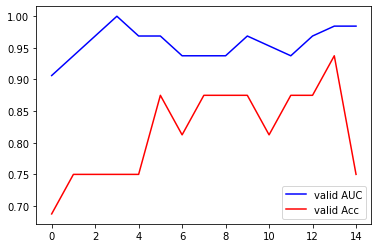

In [9]:
import matplotlib.pyplot as plt

x_len = range(len(valid_auc))
plt.plot(x_len, valid_auc, "b", label="valid AUC")
plt.plot(x_len, valid_acc, "r", label="valid Acc")
plt.legend()
plt.show()

## 5.Test Model

In [10]:
#安装timm
!pip install timm

In [11]:
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import os

#创建efficientNet模型
eff_model = timm.create_model('tf_efficientnet_b4_ns', pretrained=False, in_chans=1)

#修改model.classifier #修改前model.classifier为Linear(in_features=1792, out_features=1000, bias=True),修改后out_features=1
eff_model.classifier = nn.Sequential(
    nn.Linear(in_features=1792, out_features=625),
    nn.ReLU(inplace=True), 
    nn.Dropout(p=0.3),
    nn.Linear(in_features=625, out_features=256),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=256, out_features=1), 
)

eff_model.to(device)

save_dir = '/kaggle/working/best_auc_model_v5.pth'
dataset_path = '/kaggle/input/chest-xray-pneumonia/chest_xray'

state_dict = torch.load(save_dir)
eff_model.load_state_dict(state_dict)

eff_model.eval()
auc, acc = evaluate(eff_model, data_path=dataset_path, mode='test')
print(f'(Test on best_auc_model_v4) auc: {auc} acc:{acc}')

(Test on best_auc_model_v4) auc: 0.9849879465264081 acc:0.9022435897435898


In [12]:
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import os

#创建efficientNet模型
eff_model = timm.create_model('tf_efficientnet_b4_ns', pretrained=False, in_chans=1)

#修改model.classifier #修改前model.classifier为Linear(in_features=1792, out_features=1000, bias=True),修改后out_features=1
eff_model.classifier = nn.Sequential(
    nn.Linear(in_features=1792, out_features=625),
    nn.ReLU(inplace=True), 
    nn.Dropout(p=0.3),
    nn.Linear(in_features=625, out_features=256),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=256, out_features=1), 
)

eff_model.to(device)

save_dir = '/kaggle/working/best_acc_model_v5.pth'
dataset_path = '/kaggle/input/chest-xray-pneumonia/chest_xray'

state_dict = torch.load(save_dir)
eff_model.load_state_dict(state_dict)

eff_model.eval()
auc, acc = evaluate(eff_model, data_path=dataset_path, mode='test')
print(f'(Test on best_acc_model_v4) auc: {auc} acc:{acc}')

(Test on best_acc_model_v4) auc: 0.9794104755643217 acc:0.9230769230769231
